In [9]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit
from matplotlib import pyplot as plt
from jaxopt import OptaxSolver
import optax

In [10]:
# Set input dimension
v = 10000

# Set data and target complexity
alpha = 0.4
beta = 0.4

D_vec = jnp.power(jnp.arange(v)+1,-2*alpha)
D = jnp.diag(D_vec)

# Define target
b = jnp.power(jnp.arange(v)+1,-beta)

In [11]:
@jit
def loss(theta,W,data):
    X, y = data
    return jnp.mean((X @ W @ theta - y)**2)

In [12]:
# Sample a batch of size B
def generate_data(B,subkey):
    Z = random.normal(subkey,shape=(B,v))
    X = D_vec * Z
    y = jnp.dot(X,b)

    return X,y

In [13]:
# Approximation of risk / test error
@jit
def risk(theta,W):
    Wtheta = W @ theta
    return jnp.sum(jnp.diag(jnp.outer(Wtheta,Wtheta)) * D_vec) + jnp.sum(D_vec * b**2) - 2 * jnp.sum(jnp.diag(W @ jnp.outer(theta,b)) * D_vec)

In [14]:
def optimize(gamma,B,flops,d,c,key):
    one = jnp.ones(shape=(d,))
    key, Z_key = random.split(key)
    Z = random.normal(Z_key, shape=(v,d)) / jnp.sqrt(d)
    W = c * jnp.outer(b,one) + Z    

    r = int(flops / (B*d))
    opt = optax.sgd(learning_rate=gamma)
    solver = OptaxSolver(opt=opt, fun=loss, maxiter=r)
    theta = jnp.zeros(d)
    key, subkey = random.split(key)
    data = generate_data(B,subkey)
    state = solver.init_state(theta, W=W, data=data)

    for _ in range(r):
        key, subkey = random.split(key)
        data = generate_data(B,subkey)
        theta, state = solver.update(theta, state, W=W, data=data)

    key, subkey = random.split(key)
    err = risk(theta,W)

    return theta, err

In [15]:
flops = jnp.logspace(4,9,6)
B = 1
gamma = 1e-3
dims = [1600,3200,6400]
c = 0.05
key = random.key(0)
n_flops = jnp.shape(flops)[0]
n_dims = len(dims)
risks = np.zeros((n_flops,n_dims))

for i, f in enumerate(flops):
    for j, d in enumerate(dims):
        print(f)
        key, subkey = random.split(key)
        theta, err = optimize(gamma,B,f,d,c,subkey)
        risks[i,j] = err

10000.0
10000.0
10000.0
100000.0
100000.0
100000.0
1000000.0
1000000.0
1000000.0
10000000.0
10000000.0
10000000.0
100000000.0
100000000.0
100000000.0
1000000000.0
1000000000.0
1000000000.0


Text(0, 0.5, 'Risk')

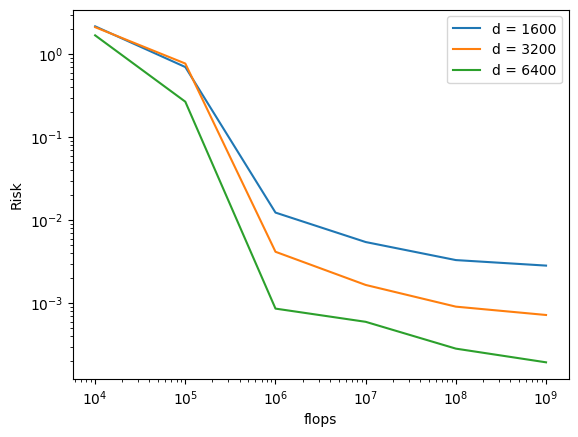

In [16]:
for j,d in enumerate(dims):
    plt.plot(flops,risks[:,j],label="d = {}".format(d))
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("flops")
plt.ylabel("Risk")